<a href="https://colab.research.google.com/github/sydney-smith/NMA_project/blob/main/Saghar_NMA_Spike_decoding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [2]:
#@title Import matplotlib and set defaults
from matplotlib import rcParams 
from matplotlib import pyplot as plt

rcParams['figure.figsize'] = [20, 4]
rcParams['font.size'] =15
rcParams['axes.spines.top'] = False
rcParams['axes.spines.right'] = False
rcParams['figure.autolayout'] = True

In [3]:
#@title Import other needed libraries

import numpy as np
import scipy as sc

from scipy import stats

In [4]:
#Data loading

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))

In [5]:
# select just one of the recordings here. 11 is nice because it has some neurons in vis ctx. I will then loop on all sessions and do this
dat = alldat[11]

# Extract some variables 
datSP = dat['spks']
vis_right = dat['contrast_right'] # 0 - low - high
vis_left = dat['contrast_left'] # 0 - low - high
response = dat['response'] # -1 - 0 - 1
dt = dat['bin_size'] # binning at 10 ms
brainArea = dat['brain_area']


#Exclusions over trials
# When both contrasts are 0
OneNonZero = (vis_left != 0) | (vis_right != 0)
# Animal does not respond despite non-zero contrast
Responded = OneNonZero & (response != 0)
# To do: I think I should exclude trials with very late responses too. Although, those might be the same as the ones I already excluded

contrastDiffs = vis_right[Responded]-vis_left[Responded]

contrastLevels = np.unique(vis_right-vis_left)

datSPIncl = datSP[:,Responded,:]
restPeriodWindow = int(500/dt/1000) #ms to data point
taskPeriodWindow = int(500/dt/1000) #ms to data point

allSp = {}
allSp['reg'] = []
allSp['rate'] = np.empty([datSPIncl.shape[0],len(contrastLevels)])
allSp['PSTH'] = np.empty([datSPIncl.shape[0],len(contrastLevels),250])
c = 0
for neuron in range(datSPIncl.shape[0]):
  #Is this neuron responsive? the first 500 ms after trial onset vs before it
  #To do: I think I should use a time before the response. It can be fixed (200 ms) or between stimulus onset and this
  ActRest = np.mean(datSPIncl[neuron,:,0:restPeriodWindow],axis = 1)
  ActTask = np.mean(datSPIncl[neuron,:,restPeriodWindow:restPeriodWindow+taskPeriodWindow],axis = 1)
  #To do: Definately should not use a t-test here. If spikes are poisson the variance is the mean. Therefore, we are not facing equal variance. Can do permuation. For now I let it be.
  tTestRes = stats.ttest_ind(ActRest, ActTask) 
  if tTestRes.pvalue < 0.05: # I don't think this need bon-ferroni or any other multiple comparison correction. We might add some neurons that by chance we thought are task responsive. That should be ok
    allSp['reg'].append(dat['brain_area'][neuron])
    # for each specific contrast difference level find the rate
    for j,contrastLevel in enumerate(contrastLevels):
      allSp['rate'][c,j]= np.mean(ActTask[contrastDiffs == contrastLevel])
      allSp['PSTH'][c,j,:] = np.mean(datSPIncl[neuron,contrastDiffs == contrastLevel,:],axis = 0)
    c += 1 


allSp['rate'] = allSp['rate'][:c,:]
allSp['PSTH'] = allSp['PSTH'][:c,:]
#np.unique(vis_right - vis_left) 

In [6]:
len(alldat)

39

In [7]:
allSp = {}
allSp['reg'] = []
allSp['rate'] = np.empty([30000,len(contrastLevels)])
allSp['PSTH'] = np.empty([30000,len(contrastLevels),250])
c = 0
for session in range(len(alldat)):
  dat = alldat[session]

  # Extract some variables 
  datSP = dat['spks']
  vis_right = dat['contrast_right'] # 0 - low - high
  vis_left = dat['contrast_left'] # 0 - low - high
  response = dat['response'] # -1 - 0 - 1
  dt = dat['bin_size'] # binning at 10 ms
  brainArea = dat['brain_area']


  #Exclusions over trials
  # When both contrasts are 0
  OneNonZero = (vis_left != 0) | (vis_right != 0)
  # Animal does not respond despite non-zero contrast
  Responded = OneNonZero & (response != 0)
  # To do: I think I should exclude trials with very late responses too. Although, those might be the same as the ones I already excluded

  contrastDiffs = vis_right[Responded]-vis_left[Responded]

  contrastLevels = np.unique(vis_right-vis_left)
  if len(contrastLevels) == len(np.unique(contrastDiffs)):
    datSPIncl = datSP[:,Responded,:]
    restPeriodWindow = int(500/dt/1000) #ms to data point
    taskPeriodWindow = int(500/dt/1000) #ms to data point


    for neuron in range(datSPIncl.shape[0]):
      #Is this neuron responsive? the first 500 ms after trial onset vs before it
      #To do: I think I should use a time before the response. It can be fixed (200 ms) or between stimulus onset and this
      ActRest = np.mean(datSPIncl[neuron,:,0:restPeriodWindow],axis = 1)
      ActTask = np.mean(datSPIncl[neuron,:,restPeriodWindow:restPeriodWindow+taskPeriodWindow],axis = 1)
      #To do: Definately should not use a t-test here. If spikes are poisson the variance is the mean. Therefore, we are not facing equal variance. Can do permuation. For now I let it be.
      tTestRes = stats.ttest_ind(ActRest, ActTask) 
      if tTestRes.pvalue < 0.05: # I don't think this need bon-ferroni or any other multiple comparison correction. We might add some neurons that by chance we thought are task responsive. That should be ok
        allSp['reg'].append(dat['brain_area'][neuron])
        # for each specific contrast difference level find the rate
        for j,contrastLevel in enumerate(contrastLevels):
          allSp['rate'][c,j]= np.mean(ActTask[contrastDiffs == contrastLevel])
          allSp['PSTH'][c,j,:] = np.mean(datSPIncl[neuron,contrastDiffs == contrastLevel,:],axis = 0)
        c += 1 


allSp['rate'] = allSp['rate'][:c,:]
allSp['PSTH'] = allSp['PSTH'][:c,:]
#np.unique(vis_right - vis_left) 

In [8]:
np.unique(allSp['reg'])

array(['ACA', 'ACB', 'APN', 'AUD', 'BLA', 'BMA', 'CA', 'CA1', 'CA2',
       'CA3', 'CL', 'COA', 'CP', 'DG', 'DP', 'EP', 'EPd', 'GPe', 'IC',
       'ILA', 'LD', 'LGd', 'LH', 'LP', 'LS', 'LSc', 'LSr', 'MB', 'MD',
       'MEA', 'MG', 'MOp', 'MOs', 'MRN', 'MS', 'NB', 'OLF', 'ORB', 'ORBm',
       'OT', 'PAG', 'PIR', 'PL', 'PO', 'POL', 'POST', 'PT', 'RN', 'RSP',
       'RT', 'SCig', 'SCm', 'SCs', 'SCsg', 'SI', 'SNr', 'SPF', 'SSp',
       'SSs', 'SUB', 'TH', 'TT', 'VAL', 'VISa', 'VISam', 'VISl', 'VISp',
       'VISpm', 'VISrl', 'VPL', 'VPM', 'ZI', 'root'], dtype='<U5')

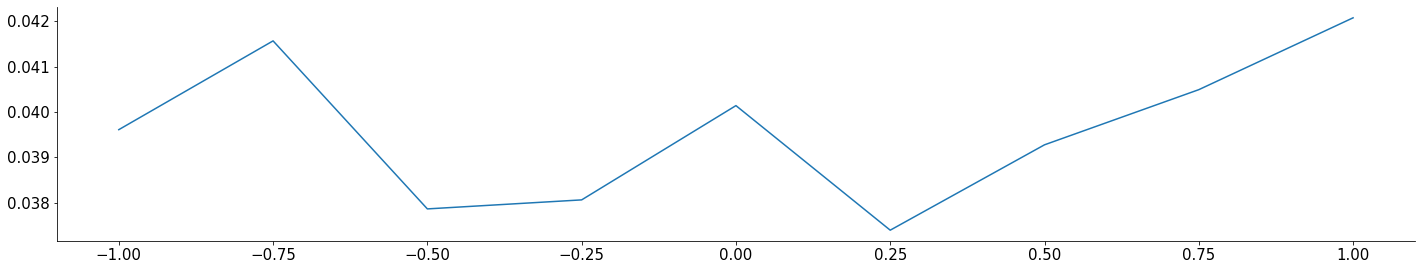

313 ACA


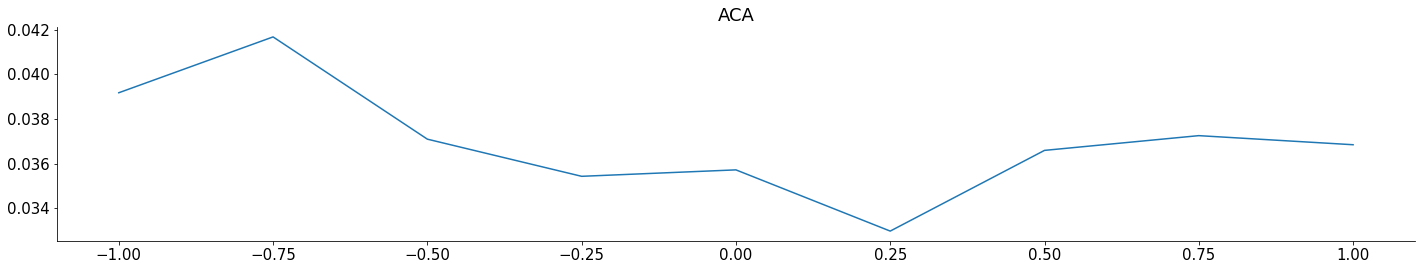

143 ACB


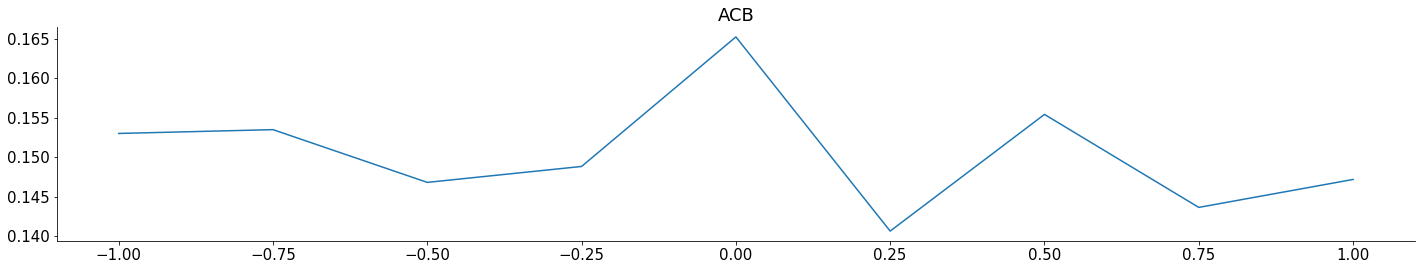

138 APN


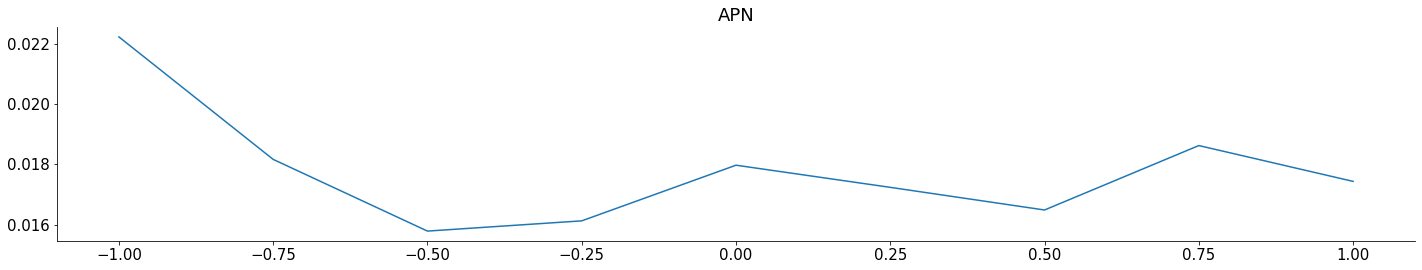

129 AUD


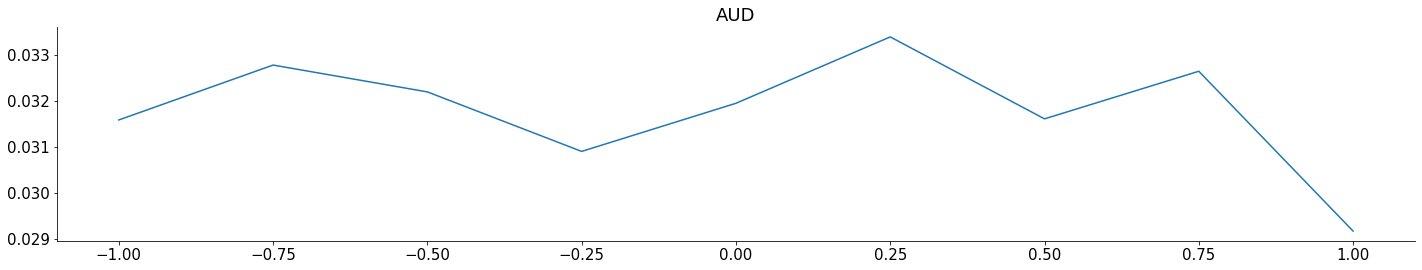

102 BLA


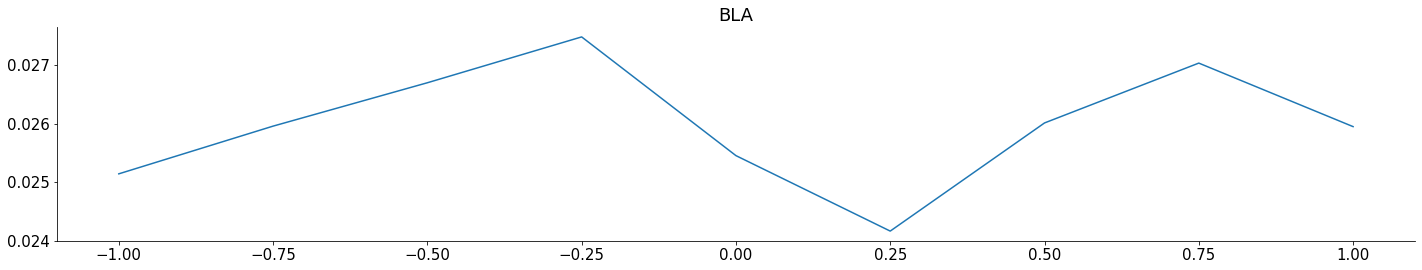

35 BMA


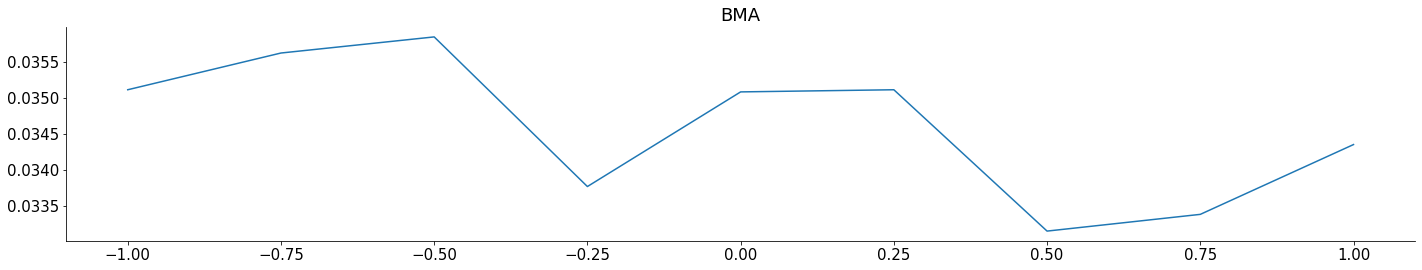

88 CA


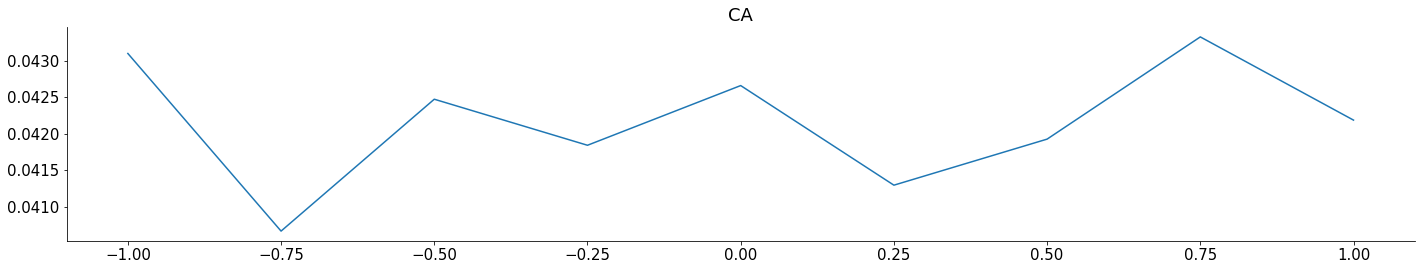

480 CA1


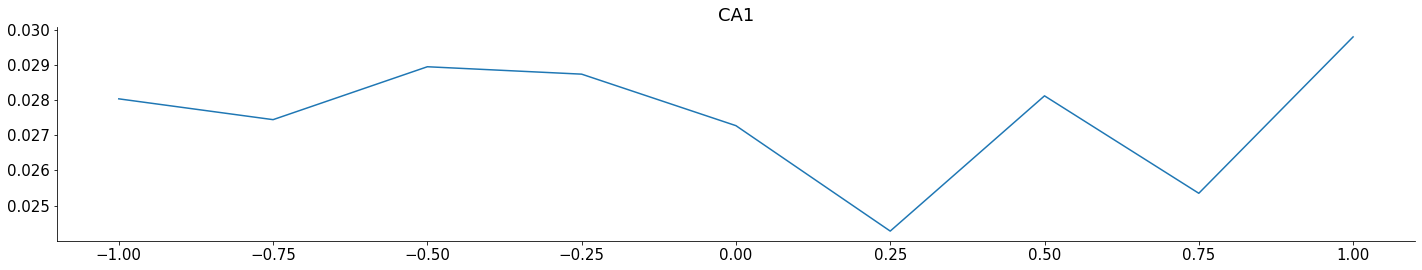

38 CA2


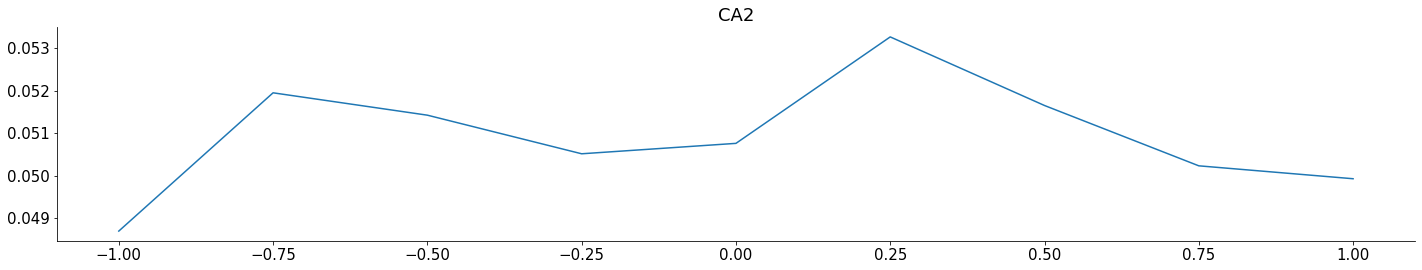

219 CA3


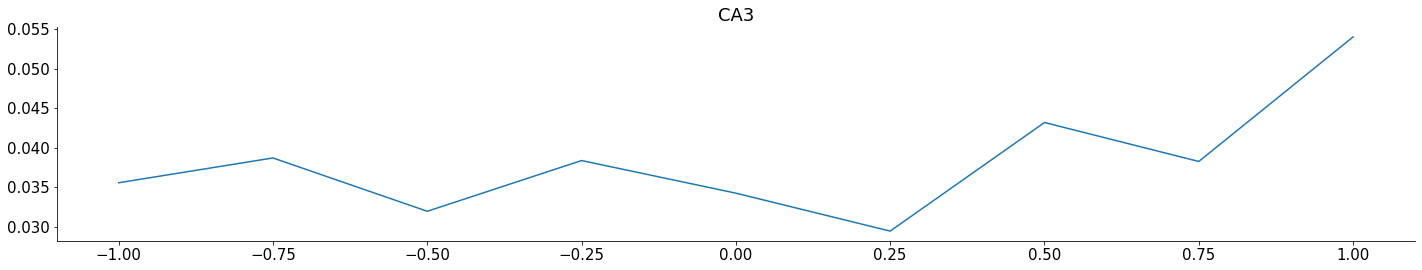

10 CL


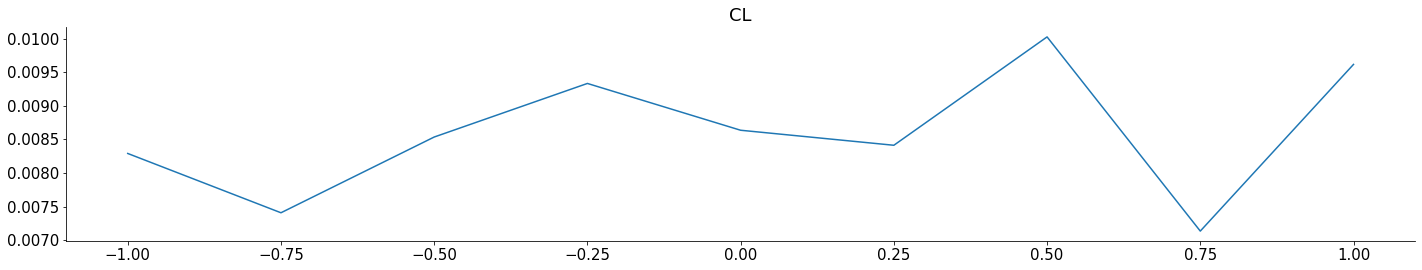

36 COA


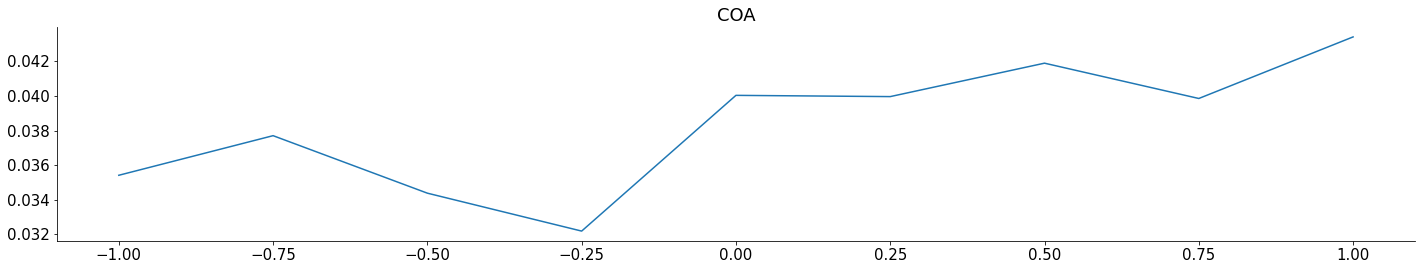

353 CP


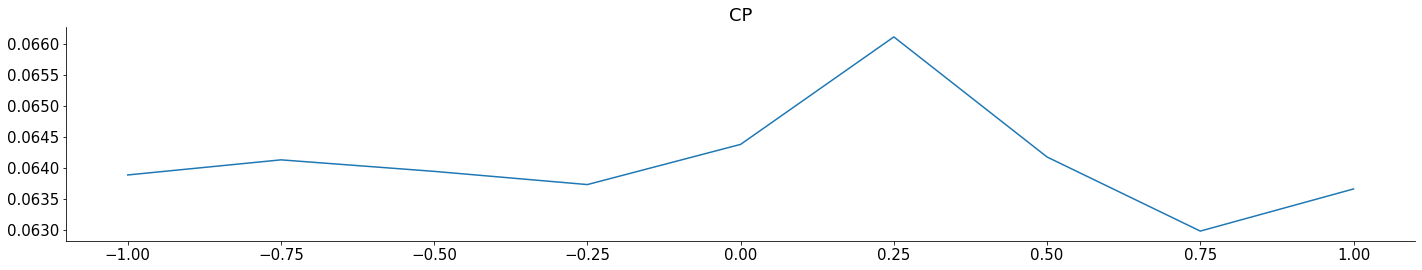

252 DG


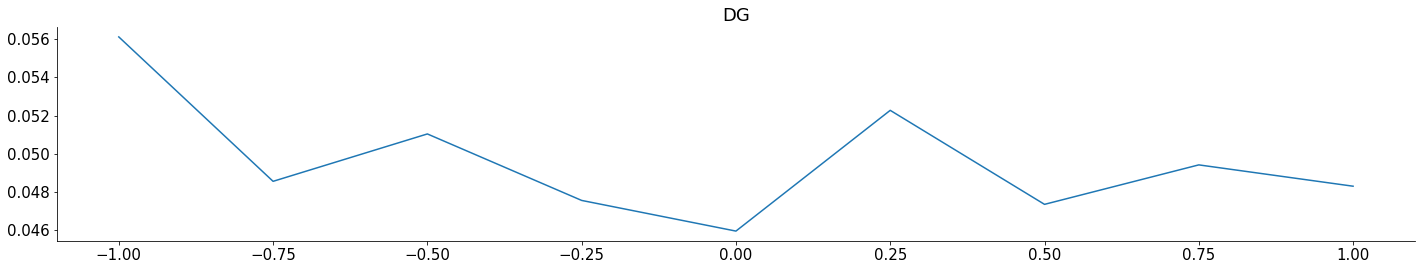

20 DP


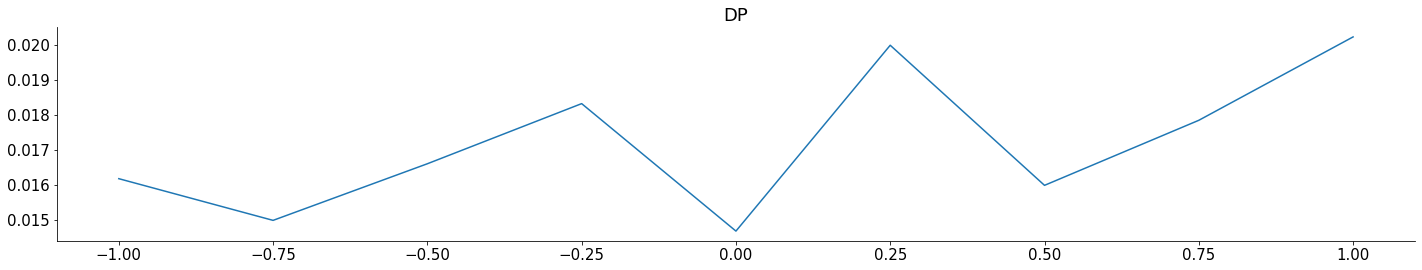

14 EP


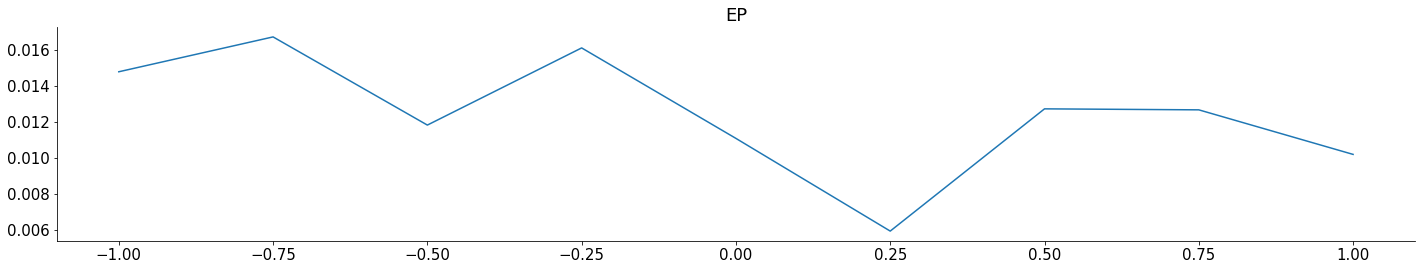

9 EPd


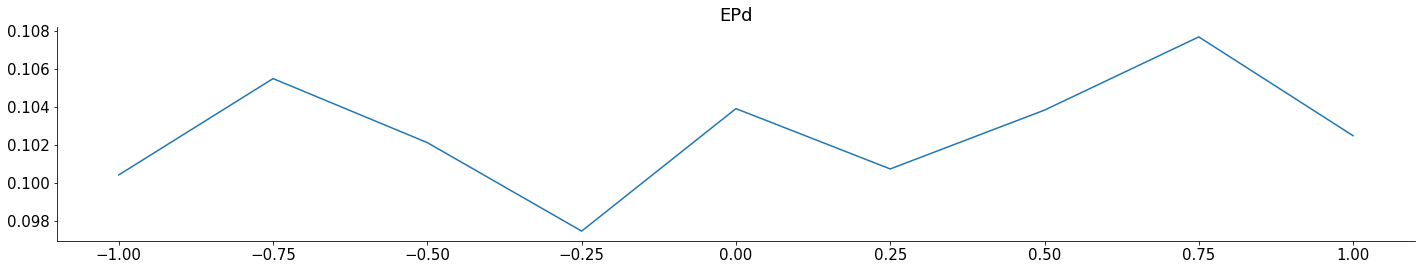

139 GPe


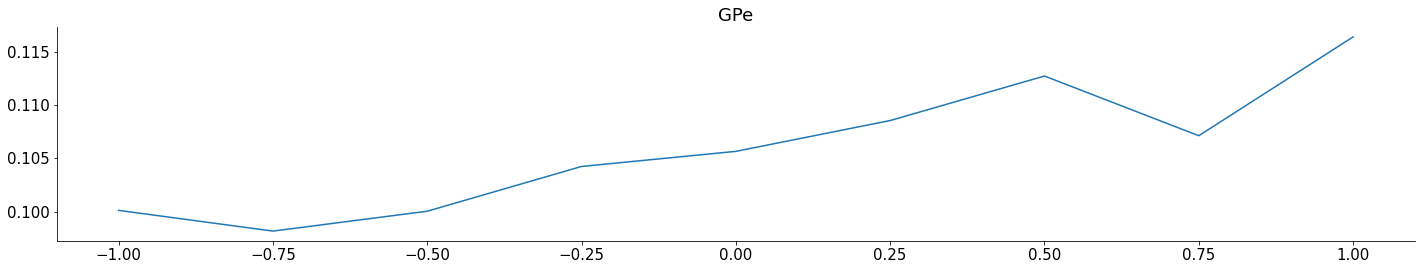

35 IC


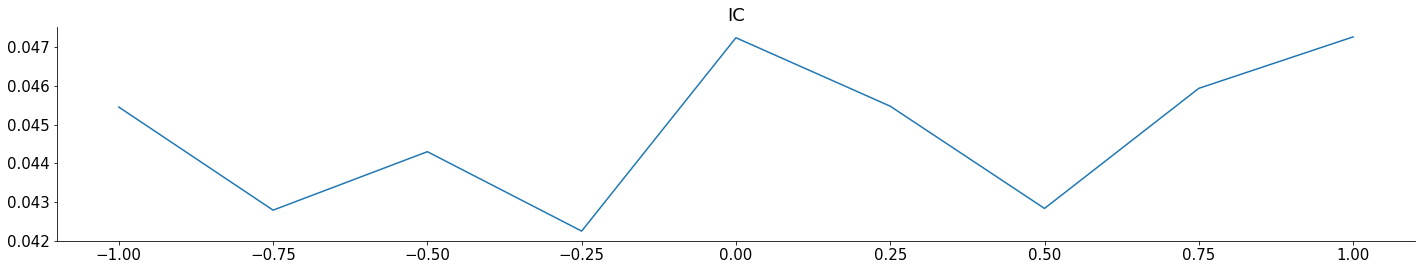

136 ILA


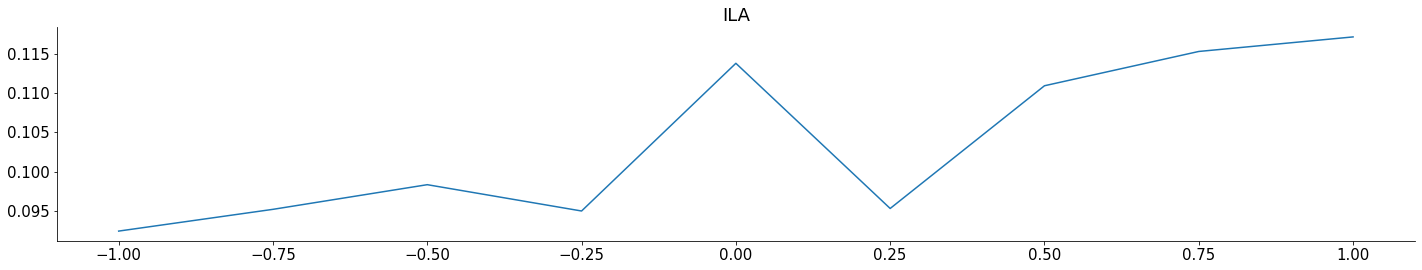

174 LD


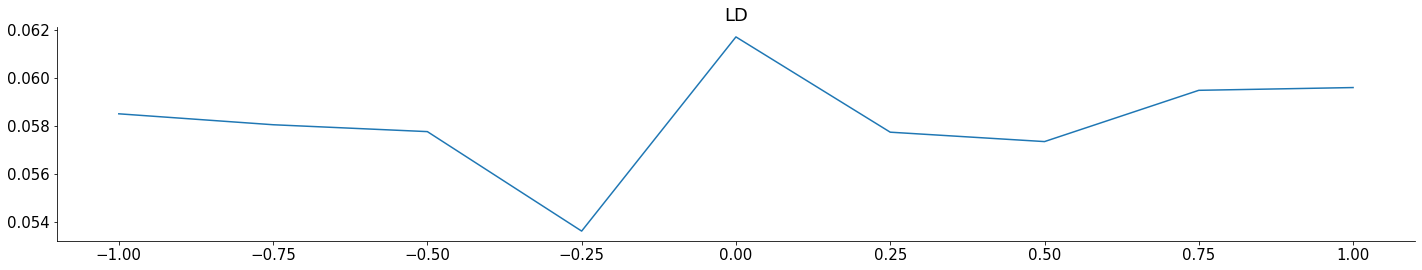

367 LGd


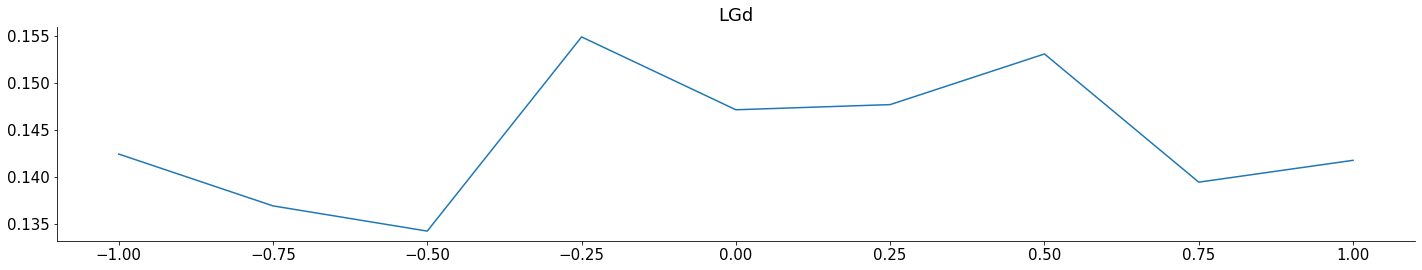

12 LH


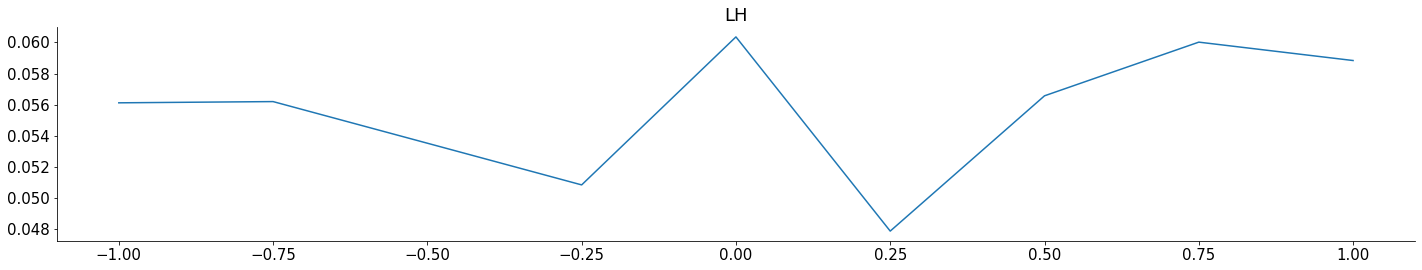

290 LP


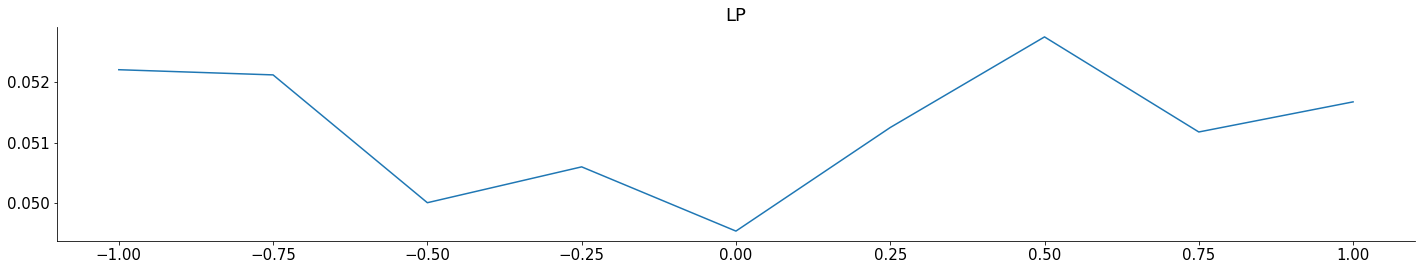

206 LS


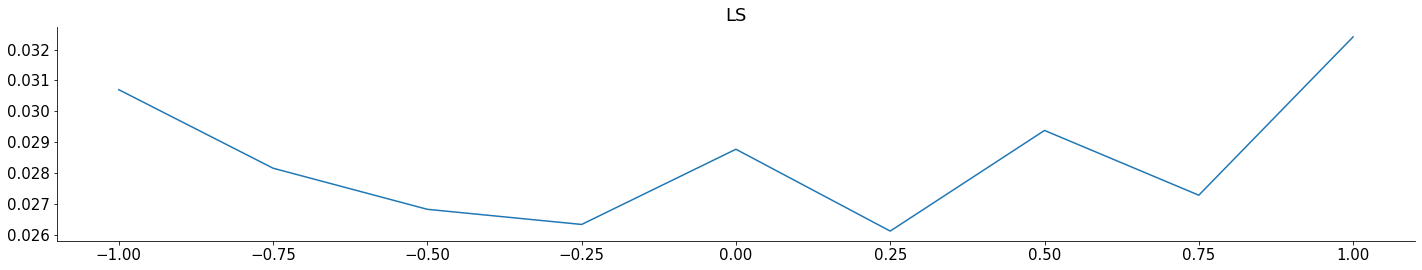

42 LSc


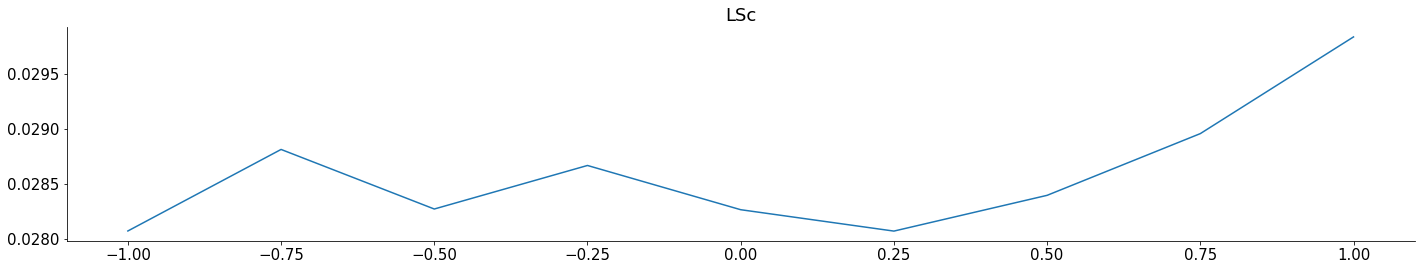

259 LSr


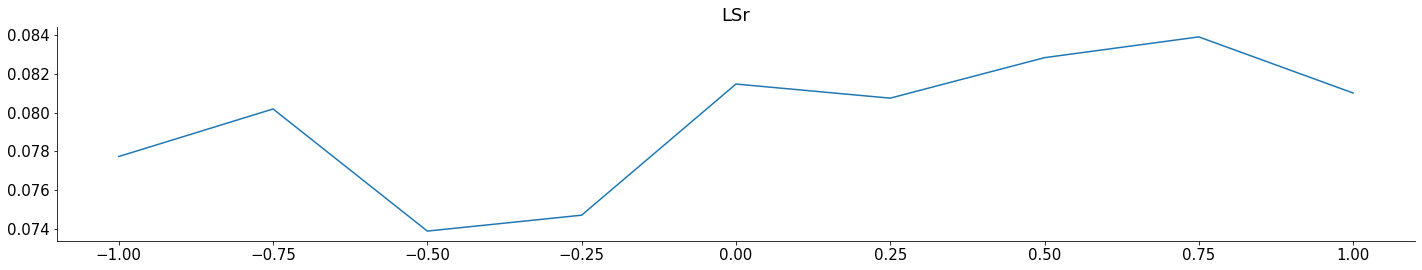

376 MB


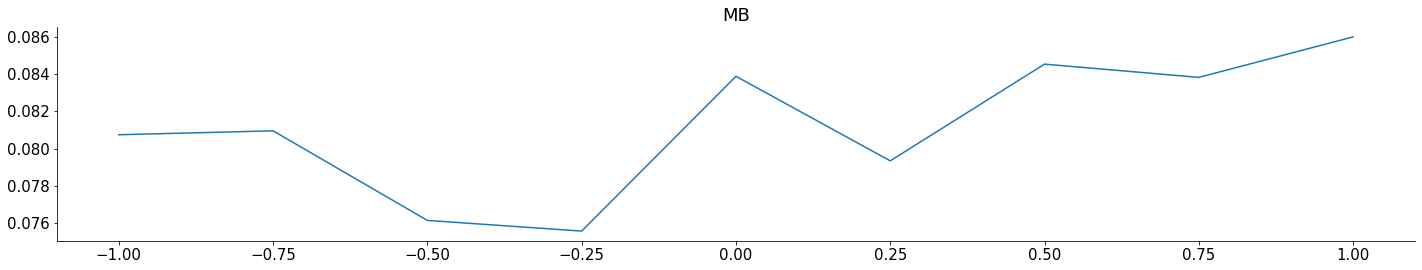

222 MD


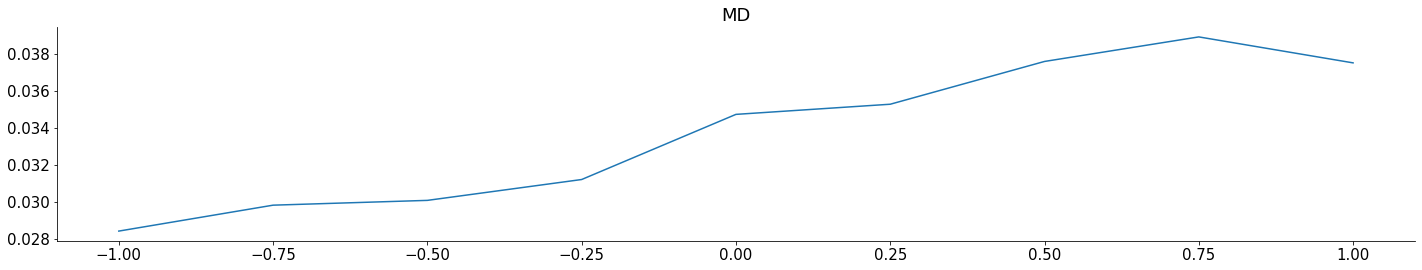

13 MEA


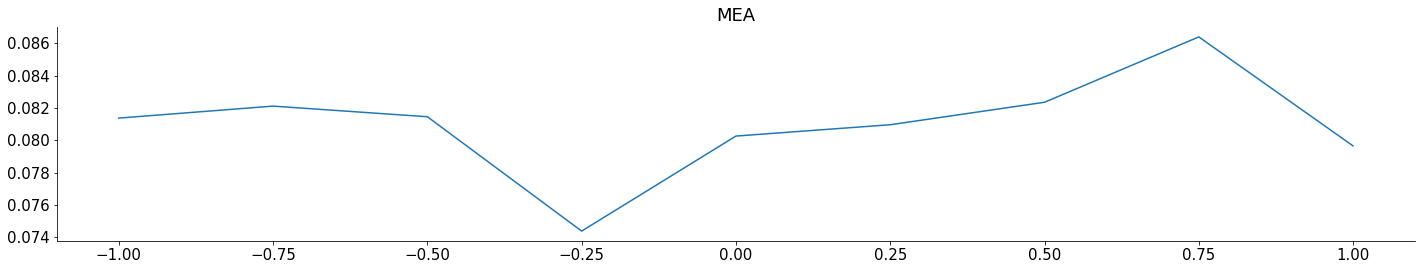

87 MG


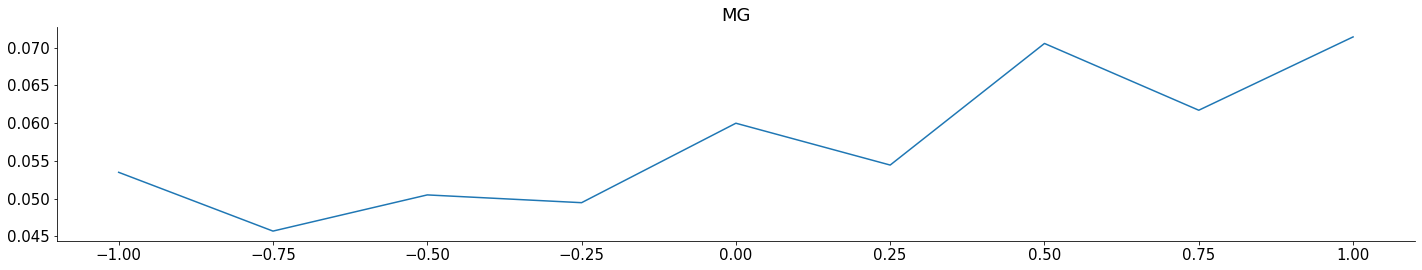

437 MOp


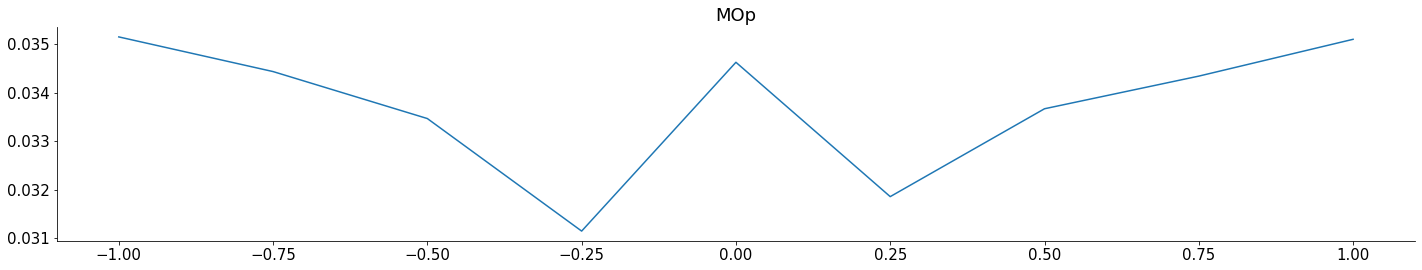

844 MOs


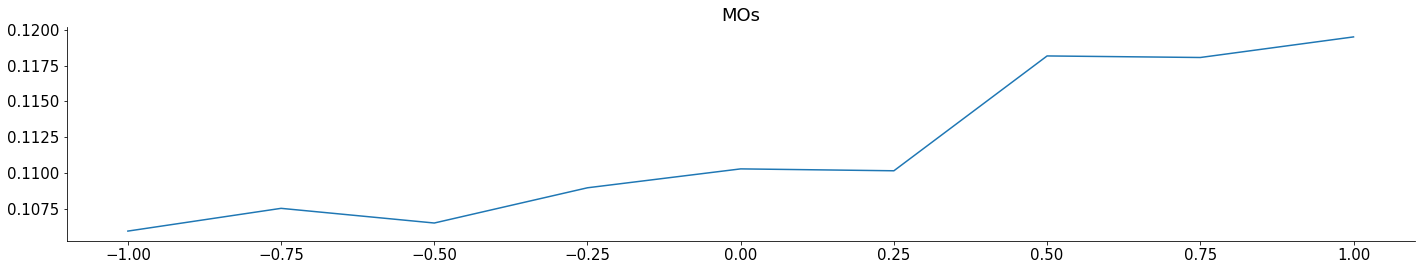

598 MRN


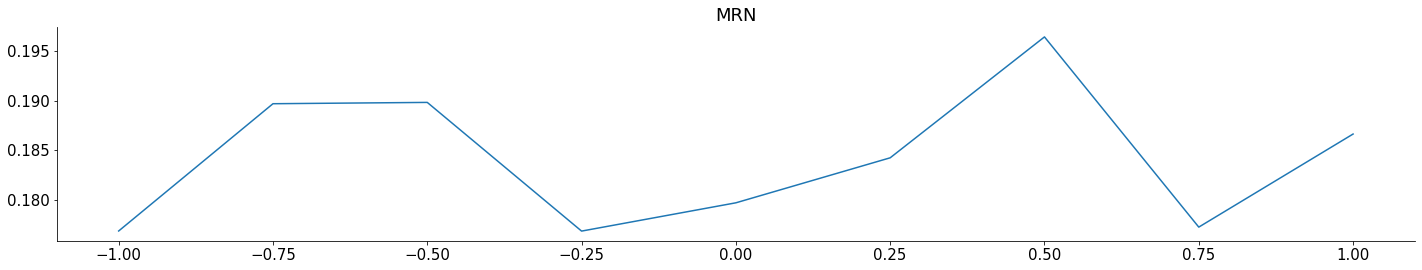

20 MS


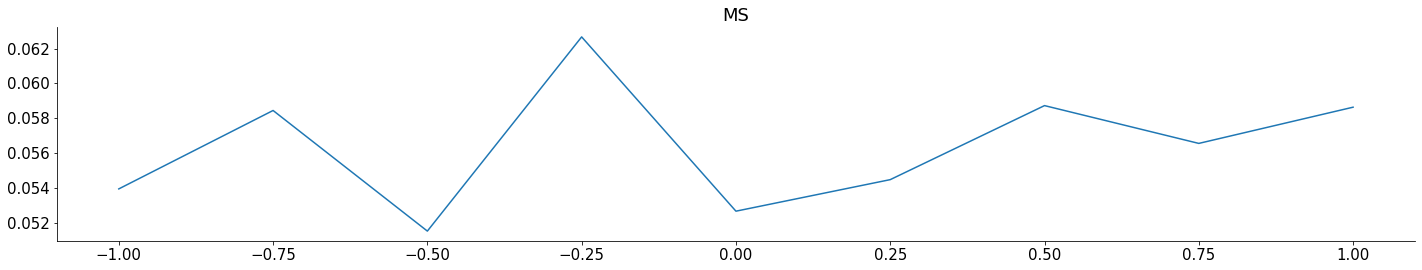

30 NB


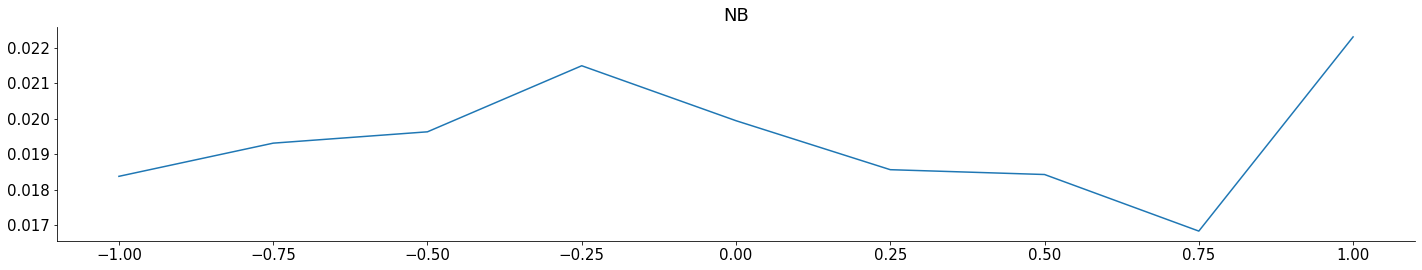

59 OLF


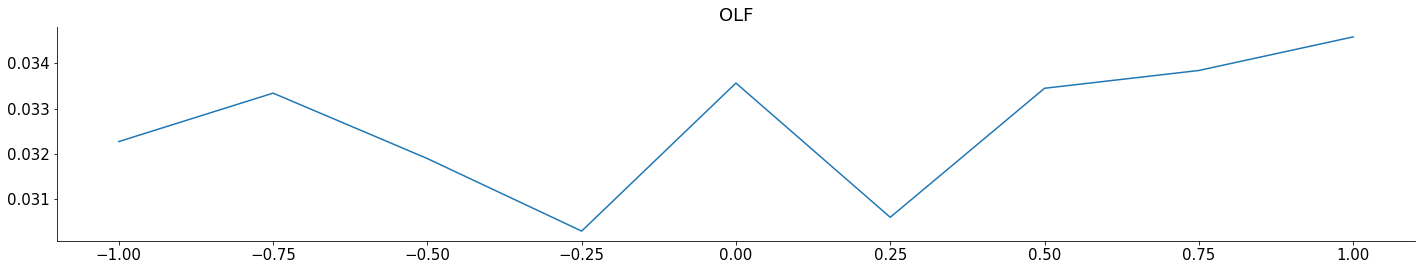

223 ORB


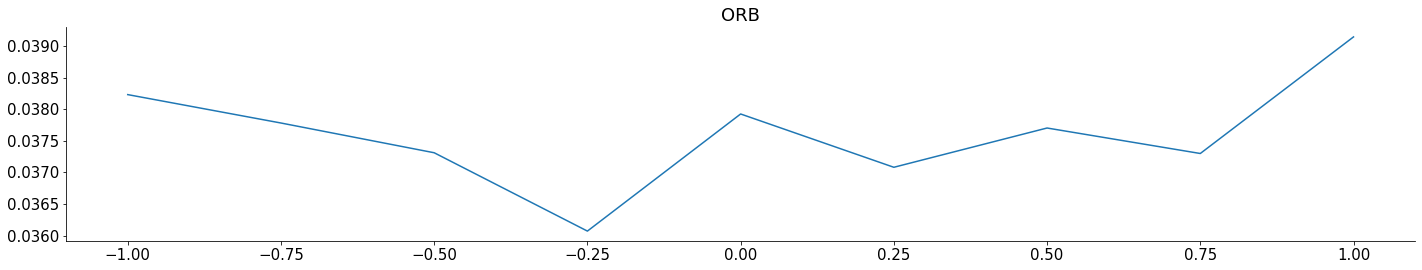

70 ORBm


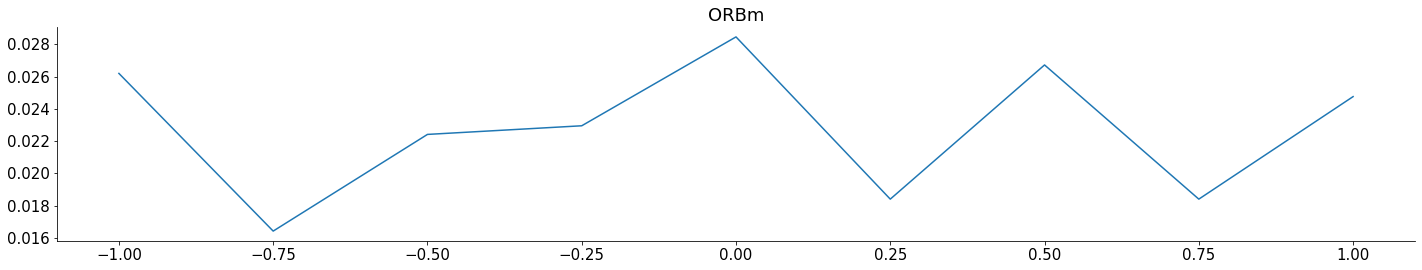

4 OT


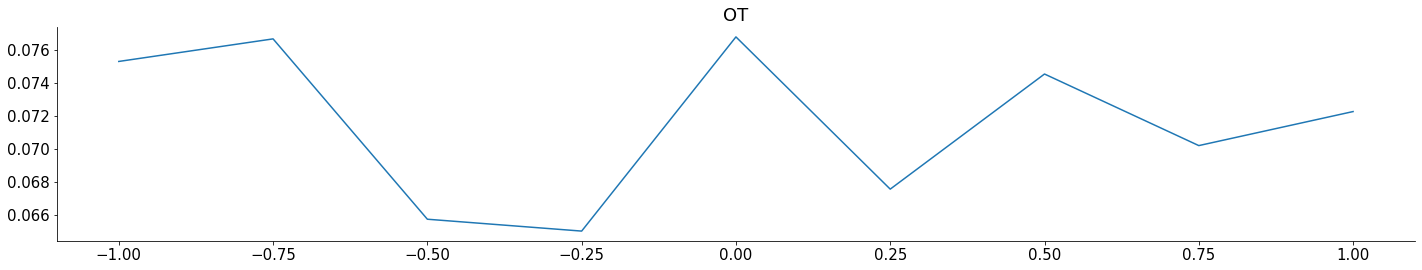

60 PAG


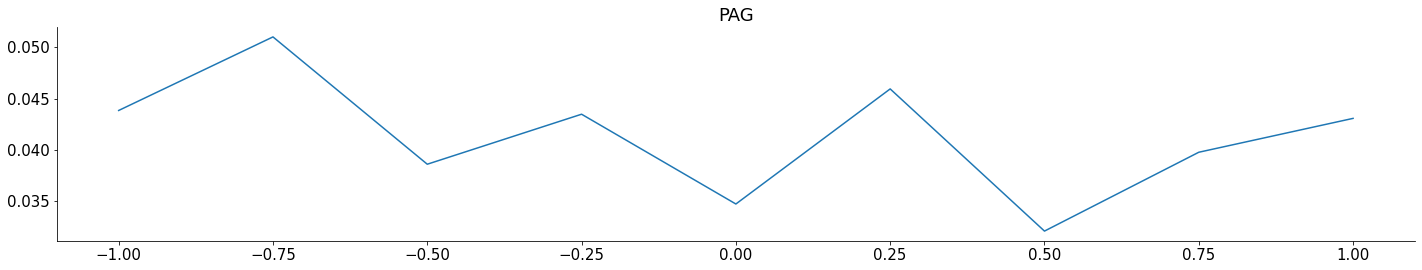

13 PIR


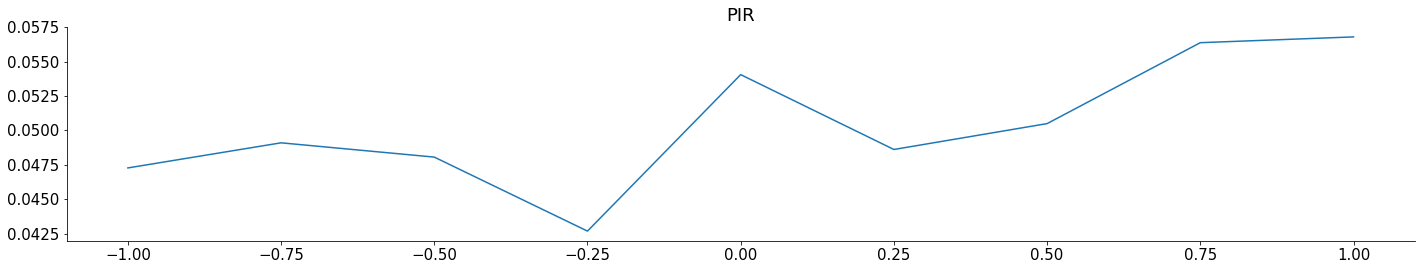

295 PL


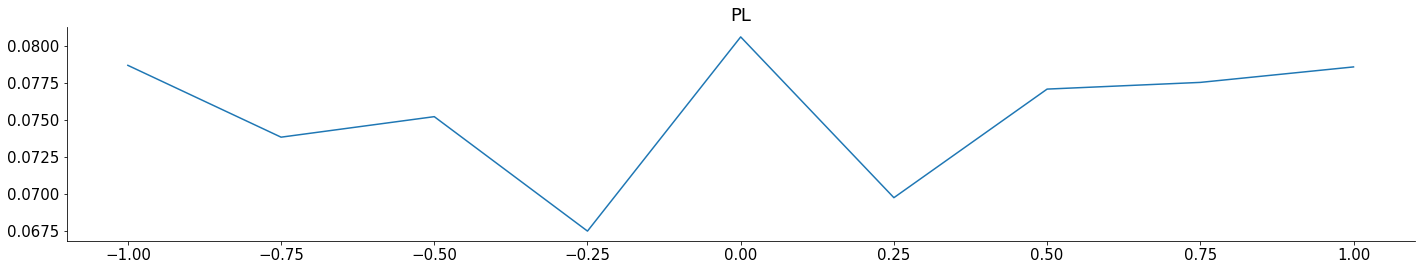

325 PO


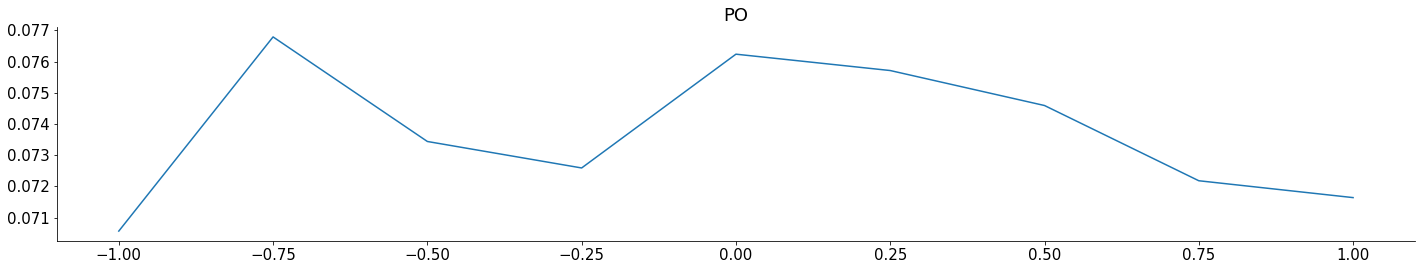

87 POL


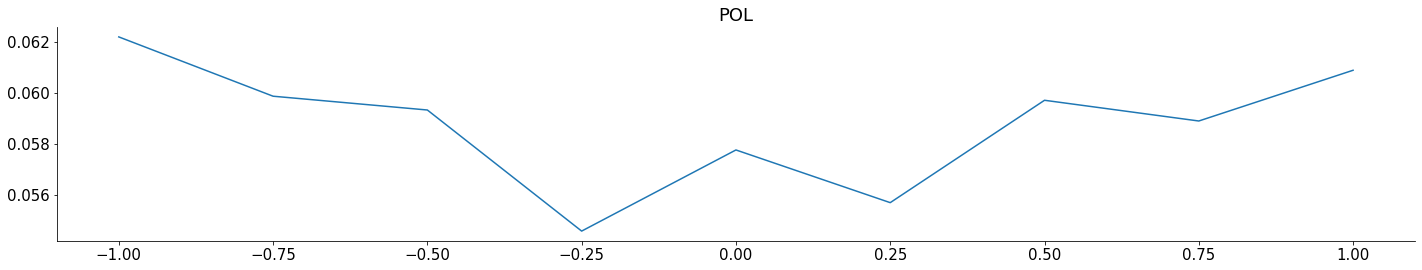

160 POST


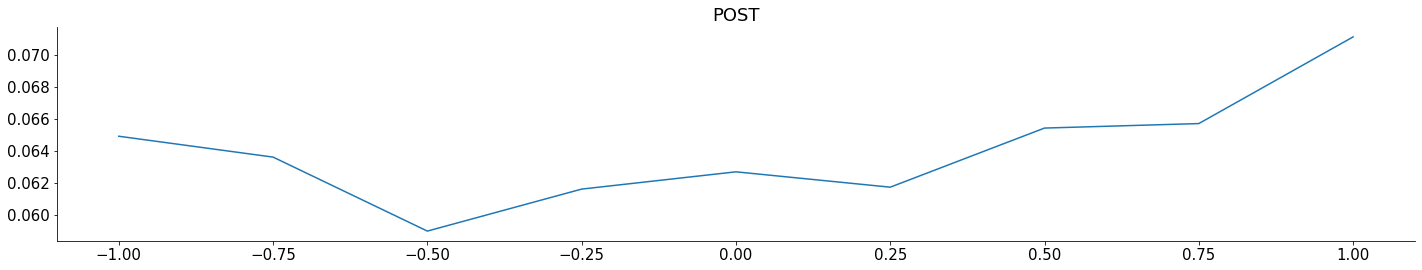

29 PT


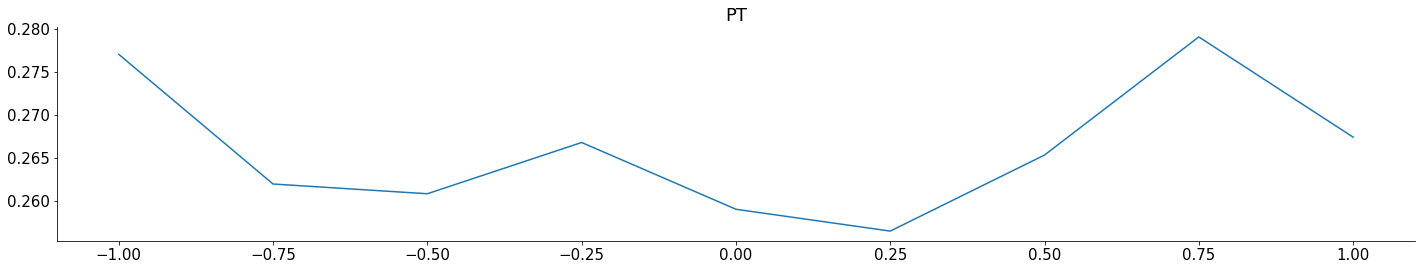

41 RN


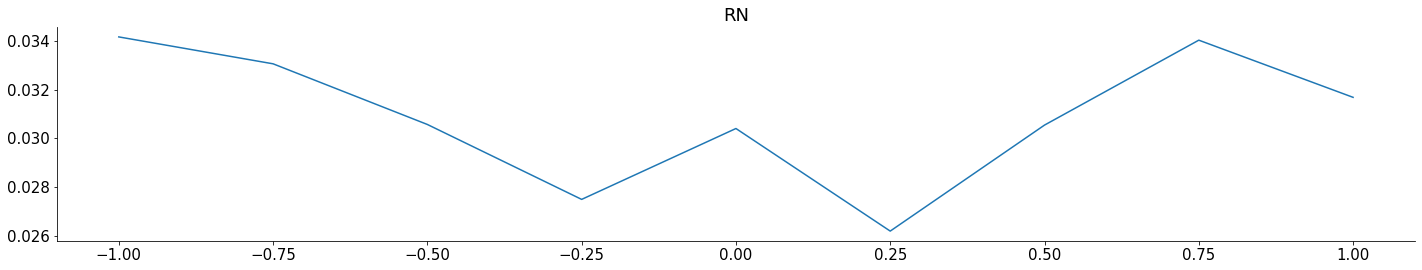

281 RSP


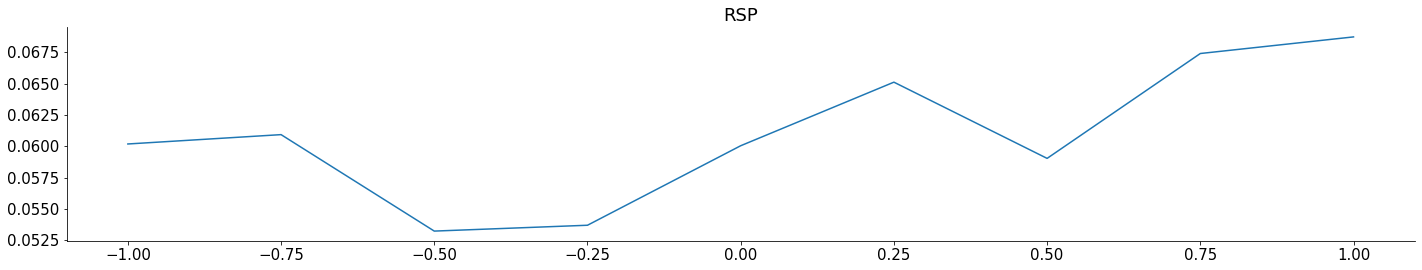

111 RT


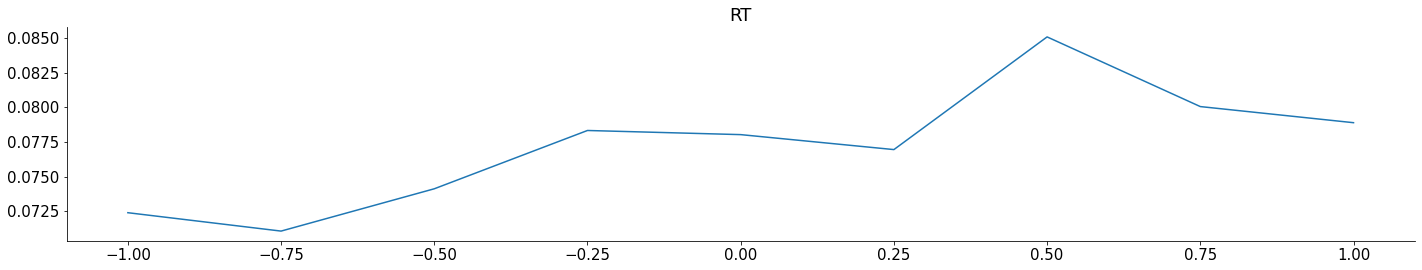

369 SCig


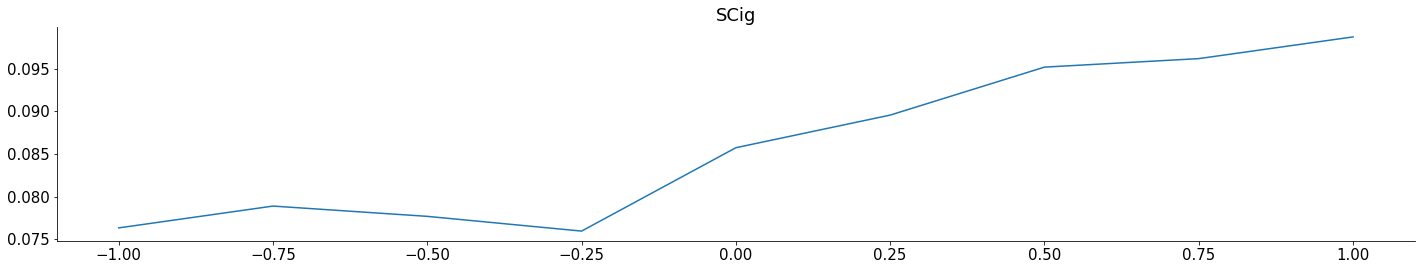

177 SCm


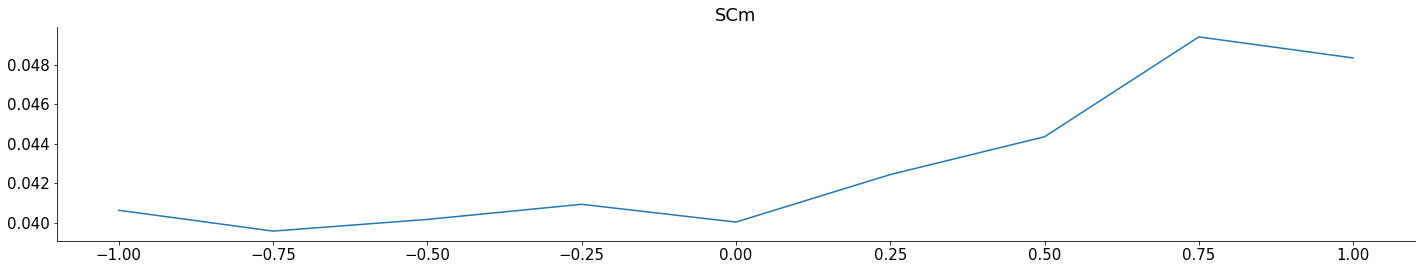

83 SCs


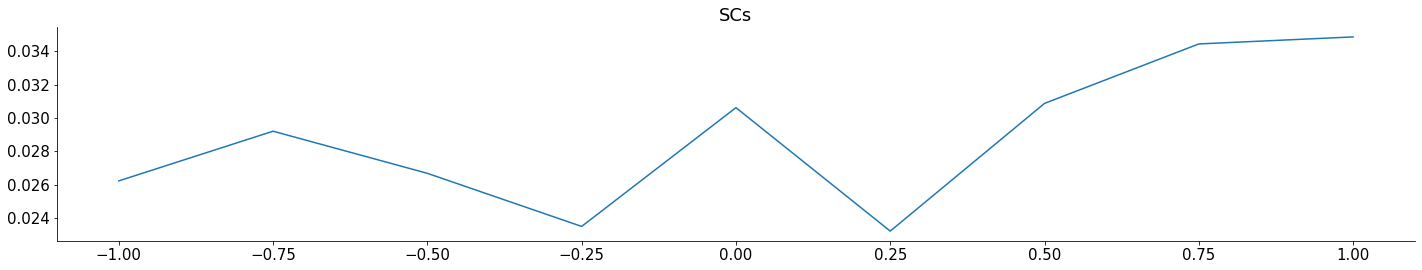

80 SCsg


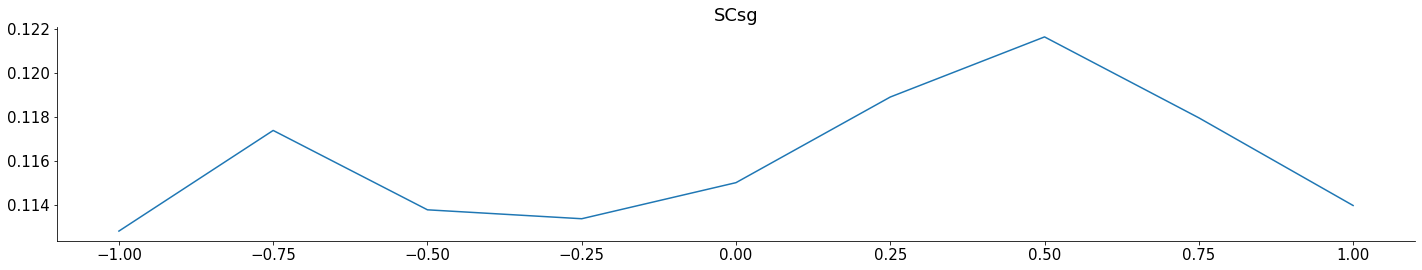

26 SI


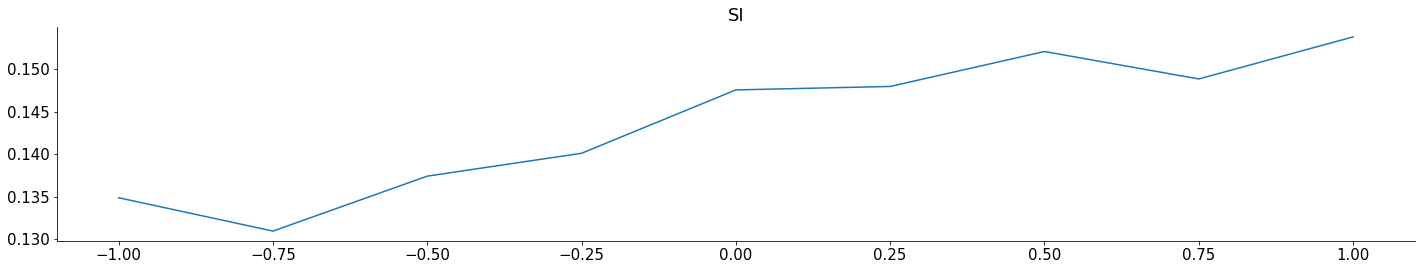

182 SNr


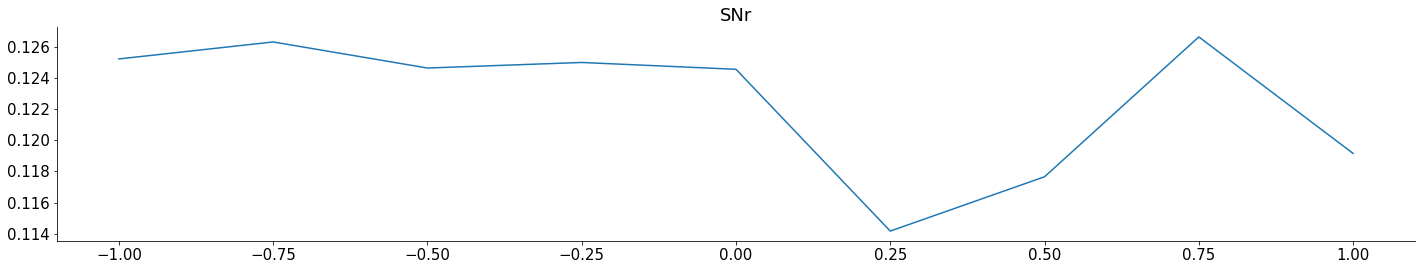

24 SPF


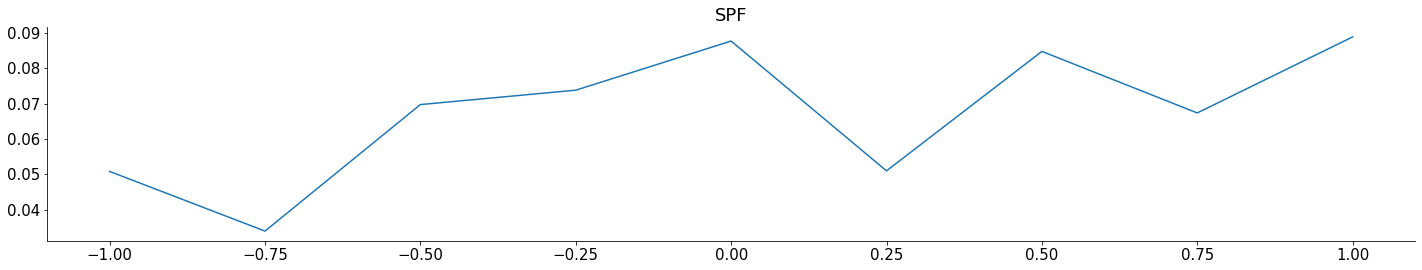

131 SSp


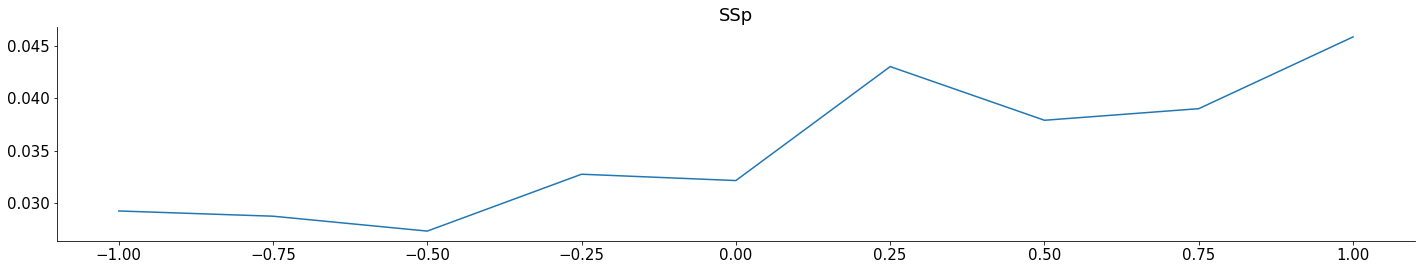

47 SSs


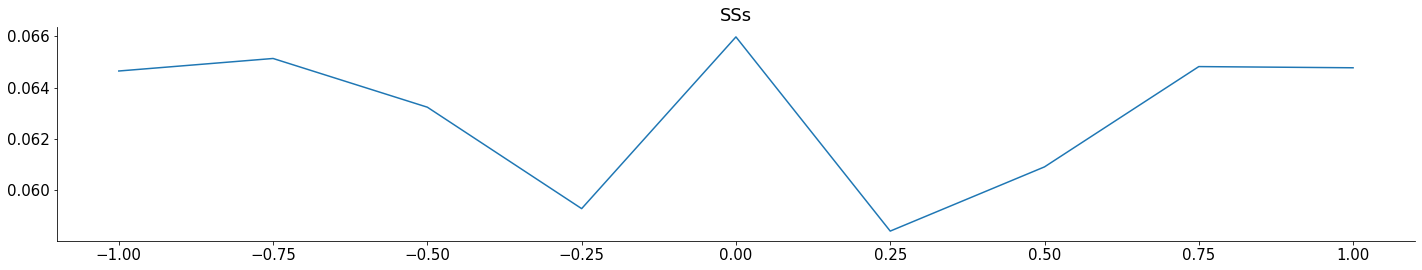

436 SUB


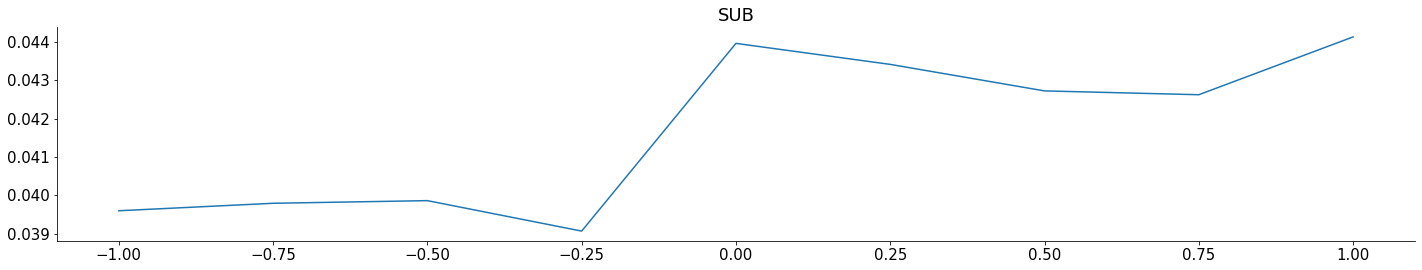

561 TH


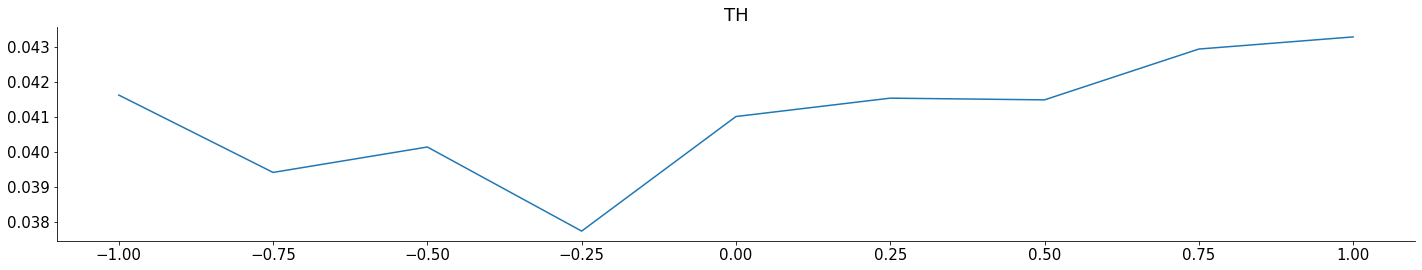

93 TT


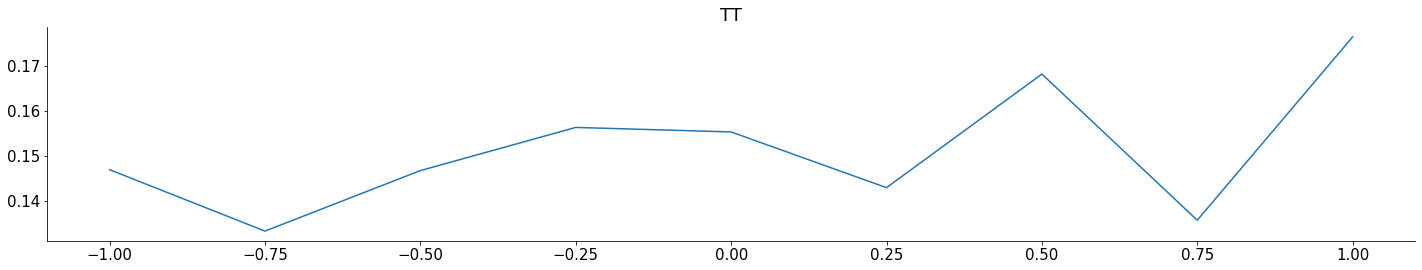

36 VAL


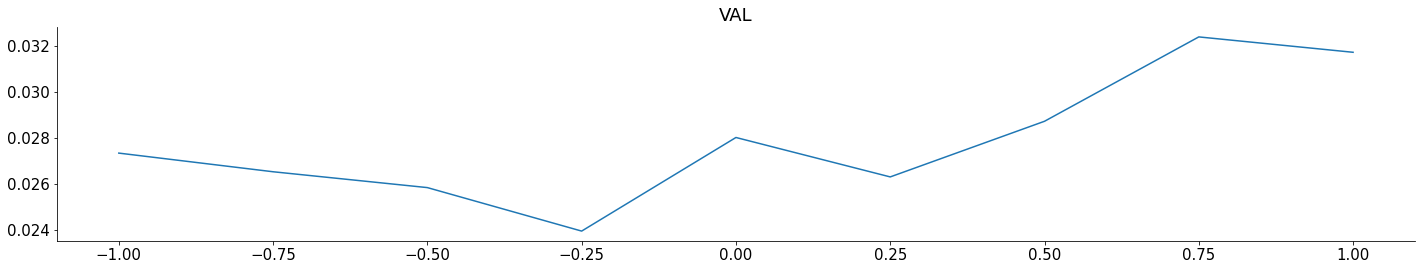

195 VISa


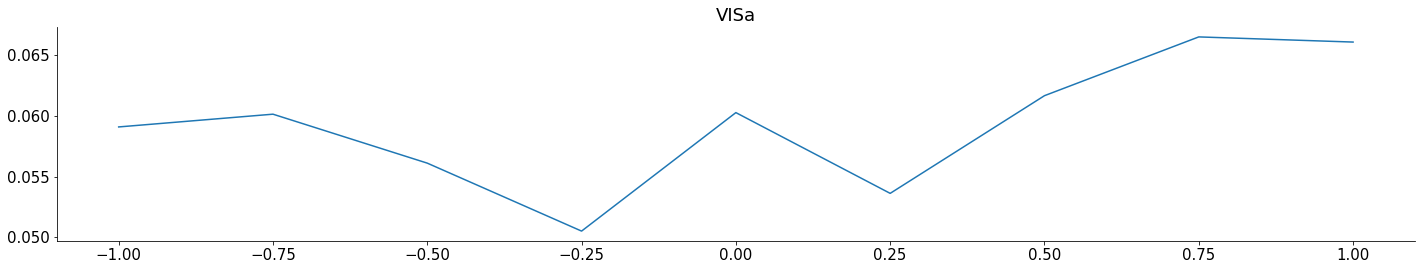

441 VISam


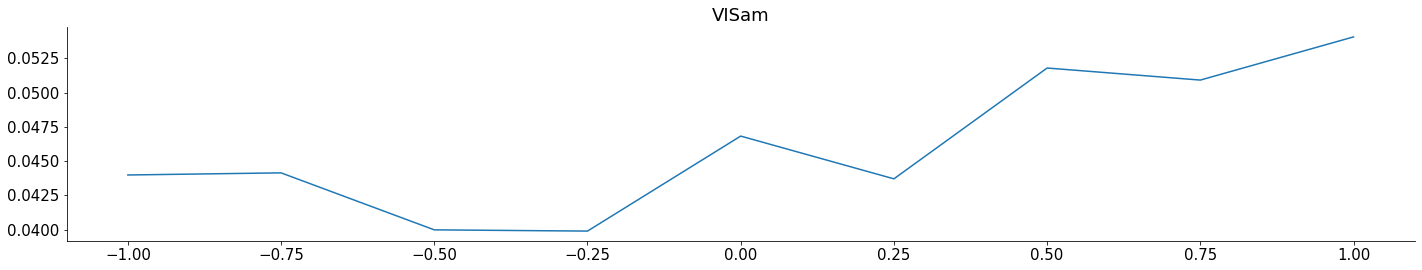

211 VISl


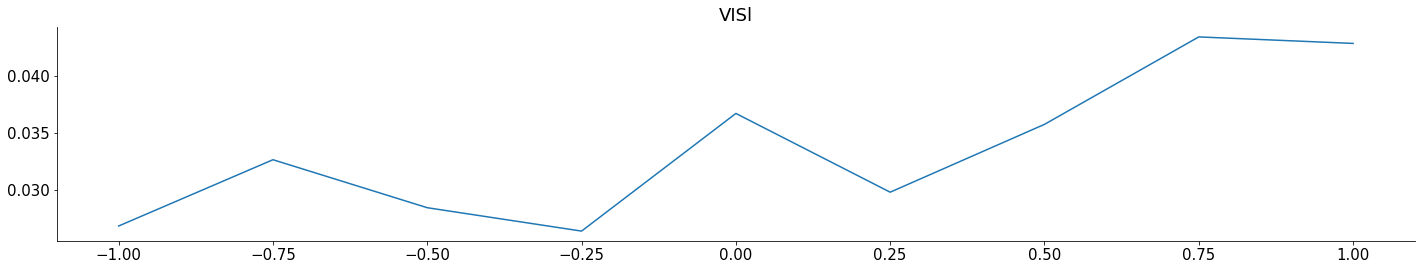

662 VISp


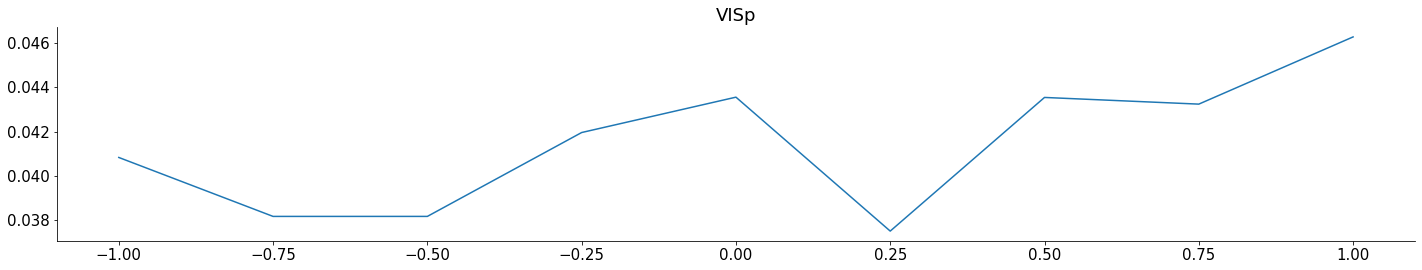

199 VISpm


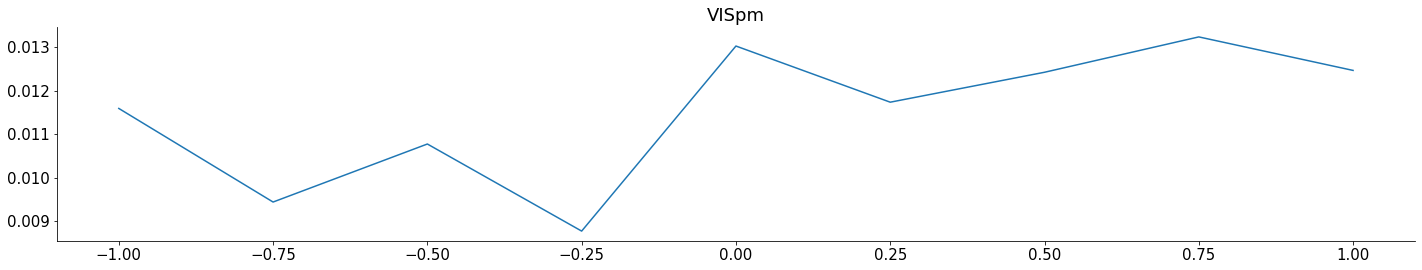

61 VISrl


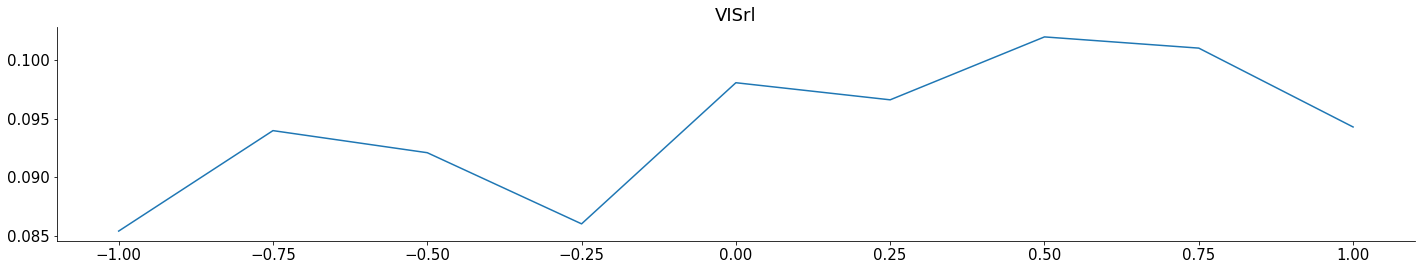

203 VPL


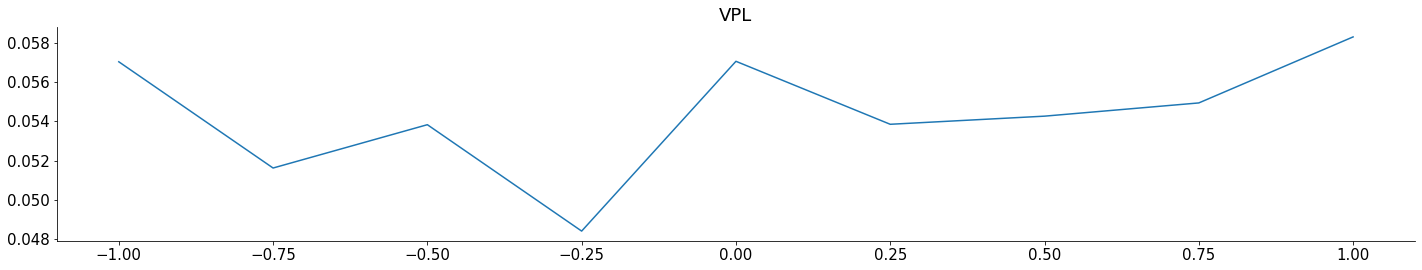

188 VPM


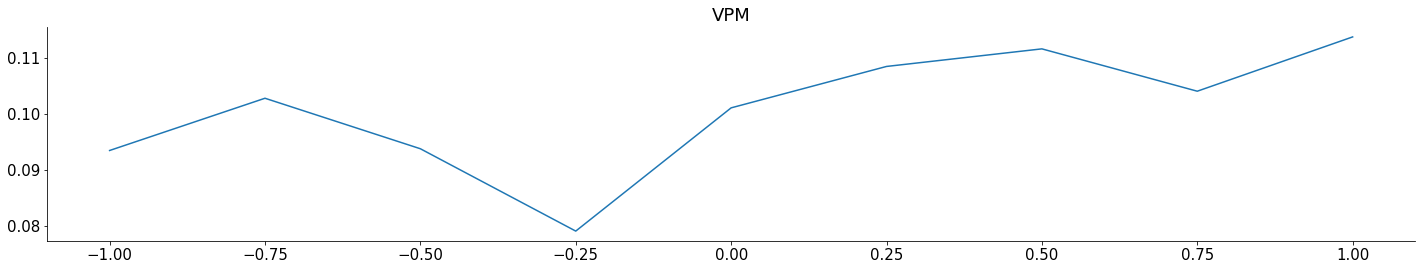

154 ZI


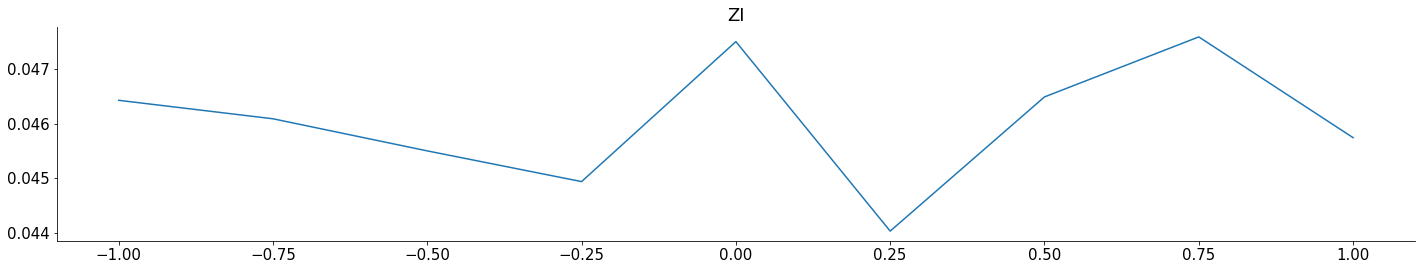

1609 root


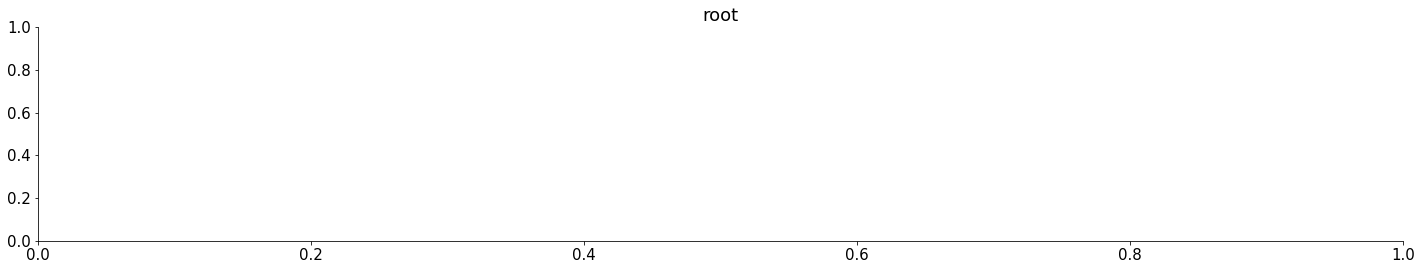

In [9]:
#plot population tuning curves
import matplotlib.pyplot as plt

regions = np.unique(allSp['reg'])

for i, region in enumerate(regions):
  plt.plot(contrastLevels, np.nanmean(allSp['rate'][np.array(allSp['reg']) == region, :],axis = 0))
  plt.show()
  plt.title(region)
  print(np.sum(np.array(allSp['reg']) == region),region)
 



In [10]:

def get_sample_cov_matrix(X):
  """
  Returns the sample covariance matrix of data X
  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
  Returns:
    (numpy array of floats)   : Covariance matrix
  """

  # Subtract the mean of X
  X = X - np.mean(X, 0)

  # Calculate the covariance matrix (hint: use np.matmul)
  cov_matrix = cov_matrix = 1 / X.shape[0] * np.matmul(X.T, X)

  return cov_matrix

In [11]:
def sort_evals_descending(evals, evectors):
  """
  Sorts eigenvalues and eigenvectors in decreasing order. Also aligns first two
  eigenvectors to be in first two quadrants (if 2D).

  Args:
    evals (numpy array of floats)    : Vector of eigenvalues
    evectors (numpy array of floats) : Corresponding matrix of eigenvectors
                                        each column corresponds to a different
                                        eigenvalue

  Returns:
    (numpy array of floats)          : Vector of eigenvalues after sorting
    (numpy array of floats)          : Matrix of eigenvectors after sorting
  """

  index = np.flip(np.argsort(evals))
  evals = evals[index]
  evectors = evectors[:, index]
  if evals.shape[0] == 2:
    if np.arccos(np.matmul(evectors[:, 0],
                           1 / np.sqrt(2) * np.array([1, 1]))) > np.pi / 2:
      evectors[:, 0] = -evectors[:, 0]
    if np.arccos(np.matmul(evectors[:, 1],
                           1 / np.sqrt(2) * np.array([-1, 1]))) > np.pi / 2:
      evectors[:, 1] = -evectors[:, 1]
  return evals, evectors

In [12]:
def change_of_basis(X, W):
  """
  Projects data onto new basis W.
  Args:
    X (numpy array of floats) : Data matrix each column corresponding to a
                                different random variable
    W (numpy array of floats) : new orthonormal basis columns correspond to
                                basis vectors
  Returns:
    (numpy array of floats)    : Data matrix expressed in new basis
  """

  # Project data onto new basis described by W
  Y = X @ W

  return Y

In [13]:
def pca(X):
  """
  Performs PCA on multivariate data.
  Args:
    X (numpy array of floats) : Data matrix each column corresponds to a
                                different random variable
  Returns:
    (numpy array of floats)   : Data projected onto the new basis
    (numpy array of floats)   : Vector of eigenvalues
    (numpy array of floats)   : Corresponding matrix of eigenvectors
  """

  # Calculate the sample covariance matrix
  cov_matrix = get_sample_cov_matrix(X)

  # Calculate the eigenvalues and eigenvectors
  evals, evectors = np.linalg.eigh(cov_matrix)

  # Sort the eigenvalues in descending order
  evals, evectors = sort_evals_descending(evals, evectors)

  # Project the data onto the new eigenvector basis
  score = change_of_basis(X, evectors)

  return score, evectors, evals

In [14]:
def get_variance_explained(evals):
  """
  Plots eigenvalues.
  Args:
    (numpy array of floats) : Vector of eigenvalues
  Returns:
    Nothing.
  """

  # Cumulatively sum the eigenvalues
  csum = np.cumsum(evals)

  # Normalize by the sum of eigenvalues
  variance_explained = csum / np.sum(evals)

  return variance_explained

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


5
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.991
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     62.67
Date:                Wed, 21 Jul 2021   Prob (F-statistic):            0.00311
Time:                        00:15:36   Log-Likelihood:                 12.131
No. Observations:                   9   AIC:                            -12.26
Df Residuals:                       3   BIC:                            -11.08
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.2737      0.234     -1.168      0

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:1535: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=9
  "anyway, n=%i" % int(n))


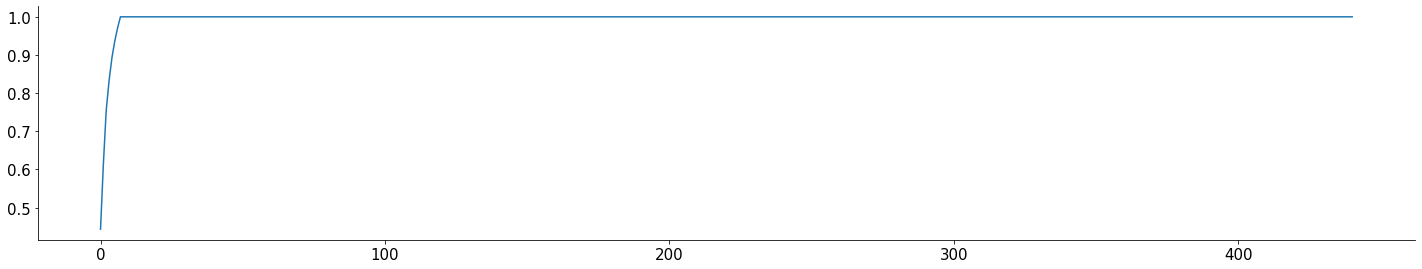

In [15]:
#Get out the data for primary visual cortex and make a design matrix. In next step I will loop over different areas 
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


areaName='VISam' #specify brain region name
data = allSp['rate'][np.array(allSp['reg']) == areaName, :].T

scores,evectors,evals = pca(data)

#plt.plot(get_variance_explained(evals))
nComponent = sum(get_variance_explained(evals)<0.90)
if nComponent<1:
  nComponent = 1

plt.plot(get_variance_explained(evals))
print(nComponent)

X =scores[:,0:nComponent]

reg = LinearRegression()
reg.fit(X,contrastLevels)

X2 = sm.add_constant(X)
est = sm.OLS(contrastLevels, X2)
est2 = est.fit()
print(est2.summary())



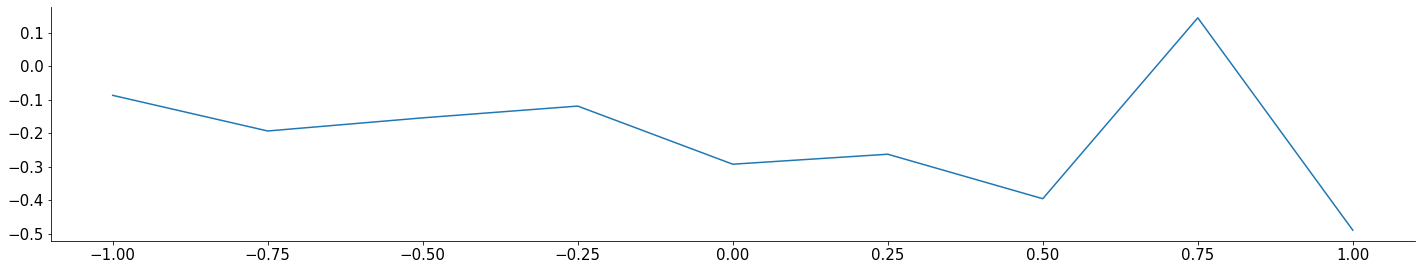

In [16]:
plt.plot(contrastLevels,scores[:,2])

960.0

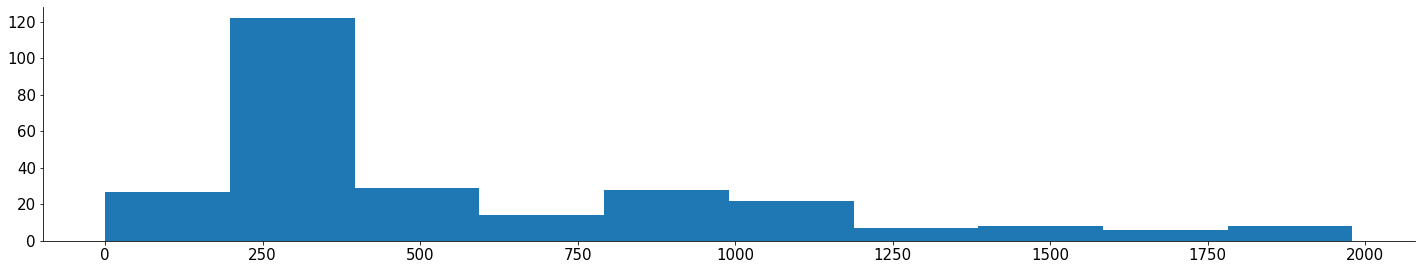

In [17]:
trialsWithResponse = dat['reaction_time'][:,1] != 0
infExcluded = dat['reaction_time'][trialsWithResponse,0]

plt.hist(infExcluded)
np.percentile(infExcluded,80)

In [18]:
#arrange data by brain region

brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP","TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]

# Assign each area an index
area_to_index = dict(root=0)
counter = 1
for group in brain_groups:
    for area in group:
        area_to_index[area] = counter
        counter += 1

alldat_brain_area_spikes = np.empty([counter,0,214,250])

for j, d in enumerate(alldat):
    for area in np.unique(d['brain_area']):
      i = area_to_index[area]
      area_neurons = d['brain_area']==area
      datSP = d['spks'][area_neurons]
      alldat_brain_area_spikes[i,:,:,:] = np.stack()  


TypeError: ignored